In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [97]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [98]:
os.chdir('/home/MA')

In [99]:
PV_size = 6 #kW_p

In [100]:
PV_production = pd.read_pickle('Calculations/CH/PV_production_CH.pkl')

Introduce curtailment introduced by grid operator to ensure stable frequency

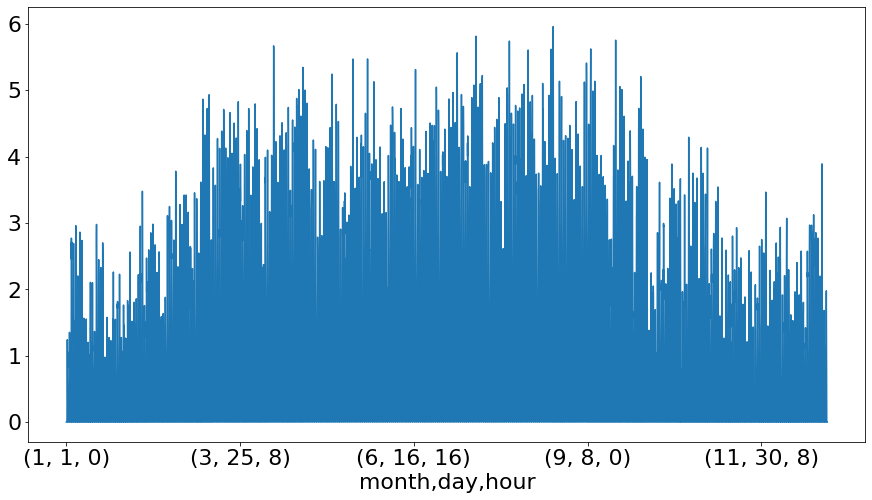

In [101]:
PV_production.plot();

**Change curtailmene HERE**

_________________________________________

In [102]:
curtailment = 0.5

__________________________________

In [103]:
max_power_allowed = curtailment*PV_size

In [104]:
PV_production_used = PV_production.copy()

In [105]:
PV_production_used[PV_production_used > max_power_allowed] = max_power_allowed

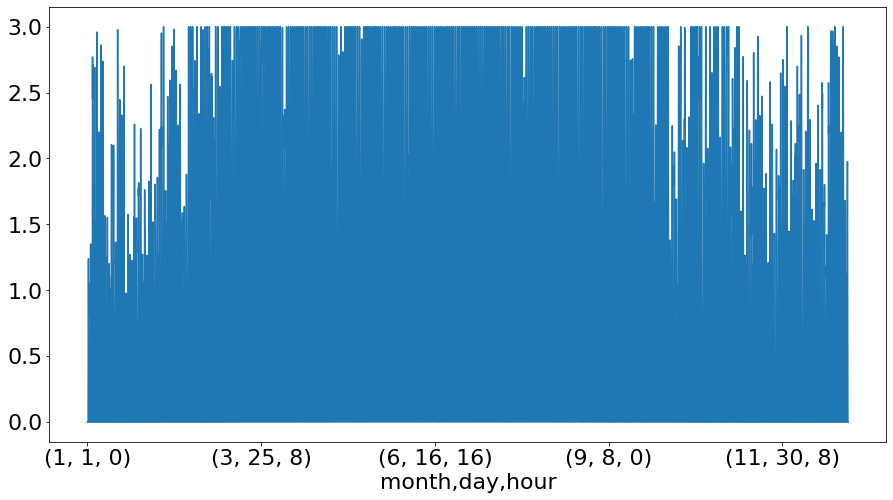

In [106]:
PV_production_used.plot();

In [107]:
PV_production_curtailed = PV_production - max_power_allowed

In [108]:
PV_production_curtailed[PV_production_curtailed < 0] = 0

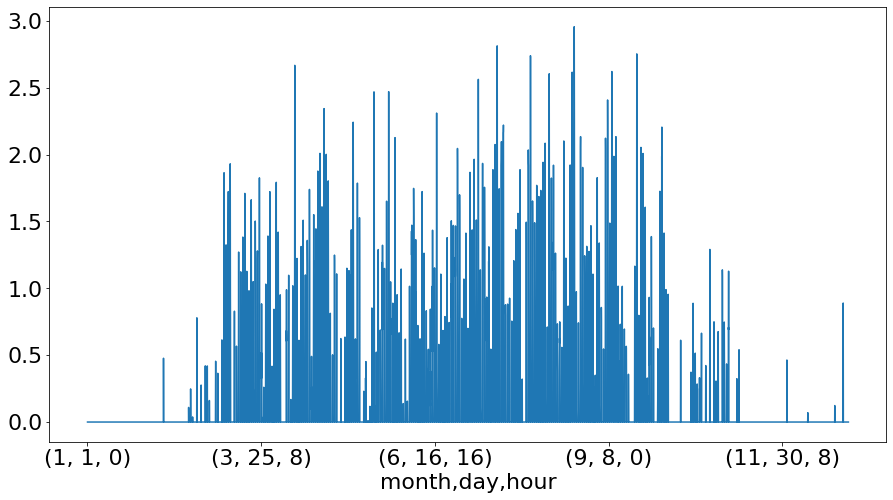

In [109]:
PV_production_curtailed.plot();

In [110]:
total_elec_load = pd.read_pickle('Calculations/CH/load_CH_modern_full_retrofit_no_AC.pkl')

In [111]:
power_balance = pd.DataFrame()

In [112]:
power_balance['consumption'] = total_elec_load

In [113]:
power_balance['from PV'] = PV_production_curtailed

In [114]:
power_balance['exchange grid'] = PV_production_curtailed - total_elec_load

In [115]:
power_balance['to Grid'] = (PV_production_curtailed - total_elec_load).clip(lower=0)

In [116]:
power_balance['from Grid'] = (total_elec_load - PV_production_curtailed).clip(lower=0)

In [117]:
power_balance = power_balance.fillna(0)

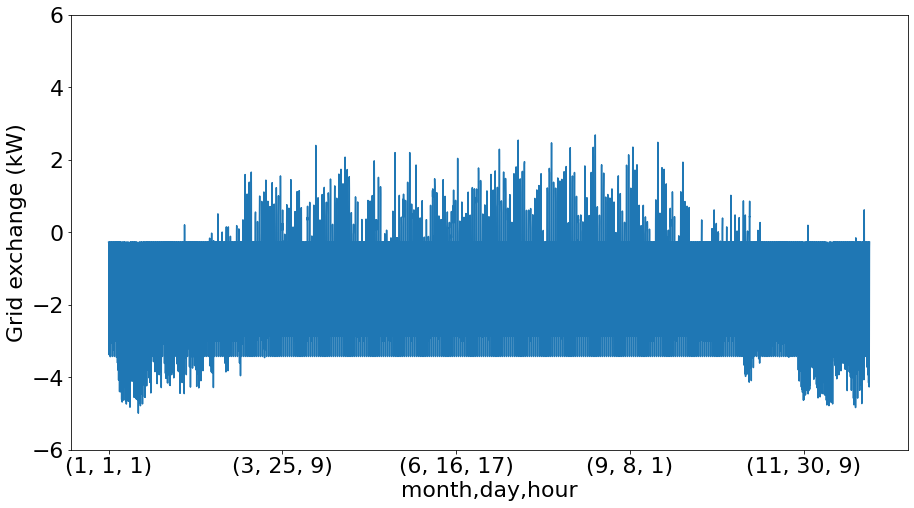

In [118]:
power_balance['exchange grid'].plot(ylabel = 'Grid exchange (kW)', ylim = ([-6, 6]));

In [119]:
power_balance.to_pickle('Calculations/CH/power_balance_CH_curtailed.pkl')

**No storage calculations**

Self-consumption share

In [120]:
sum(power_balance['consumption'] - power_balance['from Grid'])/sum(power_balance['from PV'])

0.41410886430291804

Curtailment calculation

In [121]:
sum(power_balance['to Grid'])/sum(power_balance['from PV'])

0.5858911356970821

PV share without storage

In [122]:
sum(power_balance['consumption'] - power_balance['from Grid'])/sum(power_balance['consumption'])

0.041173943873078

## Introducing battery

In [123]:
battery_size = 6

In [124]:
max_c_charge = 0.25
max_c_discharge = 0.5

Roundtrip efficiency solar battery: 85% (check alternative sources) https://www.homerenergy.com/products/pro/docs/latest/battery_roundtrip_efficiency.html#:~:text=The%20battery%20round%2Dtrip%20efficiency,Typically%20it%20is%20about%2080%25.
Assumption: Losses occur during discharging only (Charging efficiency is 99% https://www.powertechsystems.eu/home/tech-corner/lithium-ion-battery-advantages/)

In [125]:
eta_discharge = 0.85

Define function for battery dispatch

In [126]:
from Battery_dispatch_function import BatteryDispatch

In [127]:
power_balance = BatteryDispatch(power_balance, battery_size, eta_discharge, max_c_charge, max_c_discharge)

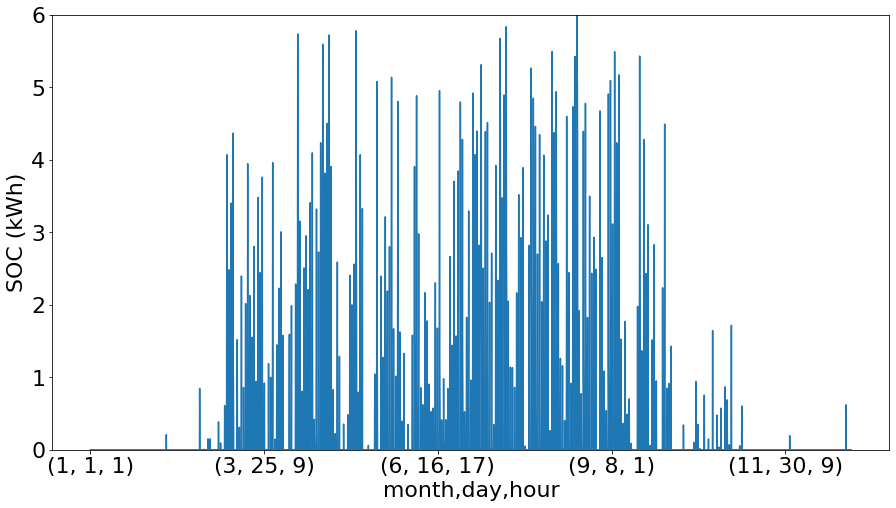

In [128]:
power_balance['SoC'].plot(ylabel = 'SOC (kWh)', ylim = ([0, 6])); 

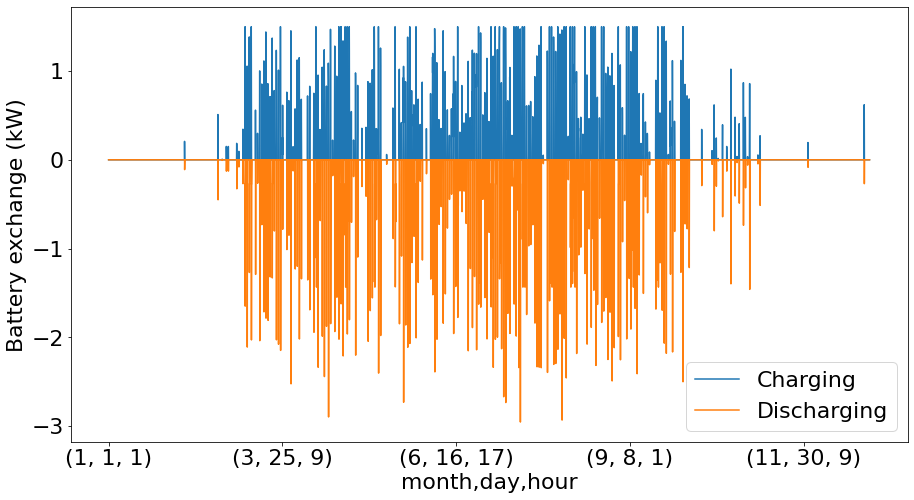

In [129]:
power_balance[['Charging', 'Discharging']].plot(ylabel = 'Battery exchange (kW)'); 

In [130]:
sum(power_balance['Charging'])

522.2768809021669

In [131]:
sum(power_balance['Discharging'])

-443.9353487668414

Check how many cycles were carried out

In [132]:
sum(power_balance['Charging'])/battery_size

87.04614681702782

In [133]:
power_balance['exchange grid new'] = power_balance['to Grid New'] - power_balance['from Grid New']

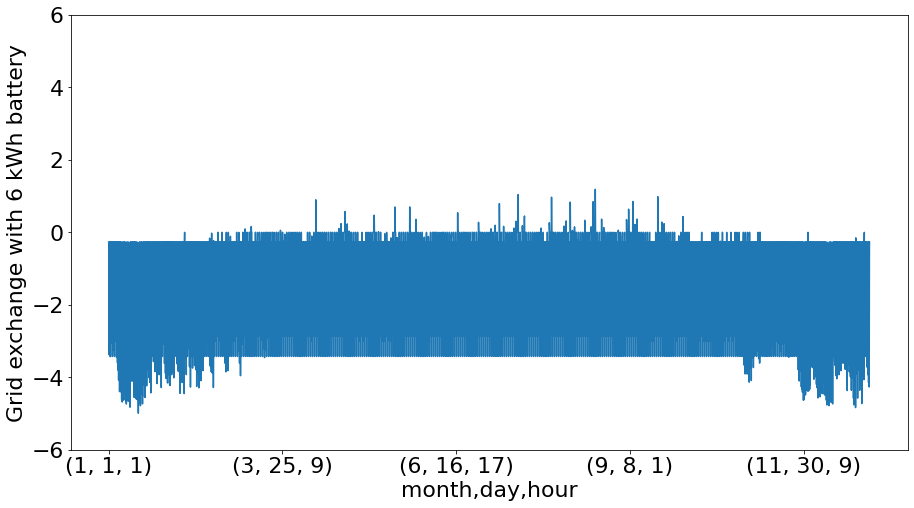

In [134]:
power_balance['exchange grid new'].plot(ylabel = 'Grid exchange with 6 kWh battery', ylim = ([-6, 6]));

Self-consumption share with BESS

In [135]:
sum(power_balance['consumption'] - power_balance['from Grid New'])/sum(power_balance['from PV'])

0.8826412257013497

Curtailment calculation with BESS

In [136]:
sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

0.03467659287541763

PV share with BESS

In [137]:
1-sum(power_balance['from Grid New'])/sum(power_balance['consumption'])

0.08775909771522217

Losses in the battery system

In [138]:
(sum(power_balance['Charging']) + sum(power_balance['Discharging']))/sum(power_balance['from PV'])

0.08268218142325016

Reduced consumption from grid:
also mention PV reduction, check with curtailment!

In [139]:
grid_savings = sum(power_balance['Discharging'])
grid_savings

-443.9353487668414

**CO$_2$ calculations**

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [141]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

In [142]:
os.chdir('/home/MA')

In [143]:
PV_lifetime = 25 #years

Emissions of grid mix at consumer level are taken from https://www.bafu.admin.ch/bafu/de/home/themen/klima/klimawandel--fragen-und-antworten.html#:~:text=Die%20Kennzahlen%20f%C3%BCr%20die%20verschiedenen,)%20(relevant%20f%C3%BCr%20volkswirtschaftliche%20Betrachtungen)

In [144]:
battery_lifetime = 15 # years

In [145]:
grid_emissions_CH= 181.5 # g CO2/kWh

Battery production energy intensity from https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

In [146]:
elec_battery_prod = 95.5 # kwh_el/kWh_n

Assumption: Battery production in China
at 637 g CO2/kWh
https://www.mdpi.com/1996-1073/14/4/961/pdf

In [147]:
CO2_intensity_China = 637

In [148]:
battery_size = [0, 6, 12, 18, 24, 72]
results = pd.DataFrame()
results['battery_size'] = battery_size
results['curtailment'] = ''
results['yearly_savings_kWh'] = ''

In [149]:
for i in range(0, len(results['battery_size'])):
    powerbalance = BatteryDispatch(power_balance, results['battery_size'].values[i], eta_discharge, max_c_charge, max_c_discharge)
    results['yearly_savings_kWh'].values[i] = -sum(power_balance['Discharging'])
    results['curtailment'].values[i] = sum(power_balance['to Grid New'])/sum(power_balance['from PV'])

In [150]:
results['total_savings_kWh'] = results['yearly_savings_kWh'] * PV_lifetime

The yearly CO2 savings by grid consumption reduction in tons amount to:

In [151]:
results['yearly_savings_CO2'] = results['yearly_savings_kWh'] * grid_emissions_CH / 1000000

For a PV lifetime of 25 years, this corresponds to a gross saving of 

In [152]:
results['total_CO2_grid_reduced'] = results['yearly_savings_CO2'] * PV_lifetime

Caclculate total battery energy intensity by accounting for dead capacity (20%) which is not used when cycling to improve performance, and for a replacement after 15 years (battery lifetime)

In [153]:
results['total_elec_battery_prod'] = 2 * (elec_battery_prod * results['battery_size']/0.8)

Net saving of battery deployment

In [154]:
results['total_CO2_battery_prod'] = results['total_elec_battery_prod'] * CO2_intensity_China / 1000000

In [155]:
results['net_CO2_savings'] = results['total_CO2_grid_reduced'] - results['total_CO2_battery_prod'] 

In [156]:
results['stored'] = results.iloc[0]['curtailment'] - results['curtailment']

In [157]:
results

,battery_size,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored
0,0,0.585891,-0,-0,-0,-0,0.0,0.000000,-0,0
1,6,0.0346766,443.935,11098.4,0.0805743,2.01436,1432.5,0.912502,1.10185,0.551215
2,12,0,471.863,11796.6,0.0856431,2.14108,2865.0,1.825005,0.316074,0.585891
3,18,0,471.863,11796.6,0.0856431,2.14108,4297.5,2.737507,-0.596429,0.585891
4,24,0,471.863,11796.6,0.0856431,2.14108,5730.0,3.650010,-1.50893,0.585891
5,72,0,471.863,11796.6,0.0856431,2.14108,17190.0,10.950030,-8.80895,0.585891


In [158]:
results.set_index("battery_size",drop=True,inplace=True)

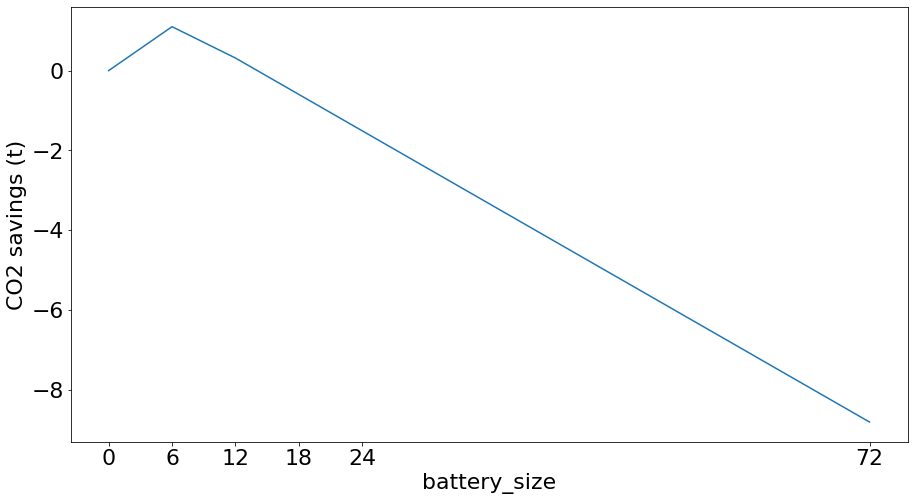

In [159]:
results['net_CO2_savings'].plot(xticks = battery_size, ylabel ='CO2 savings (t)');

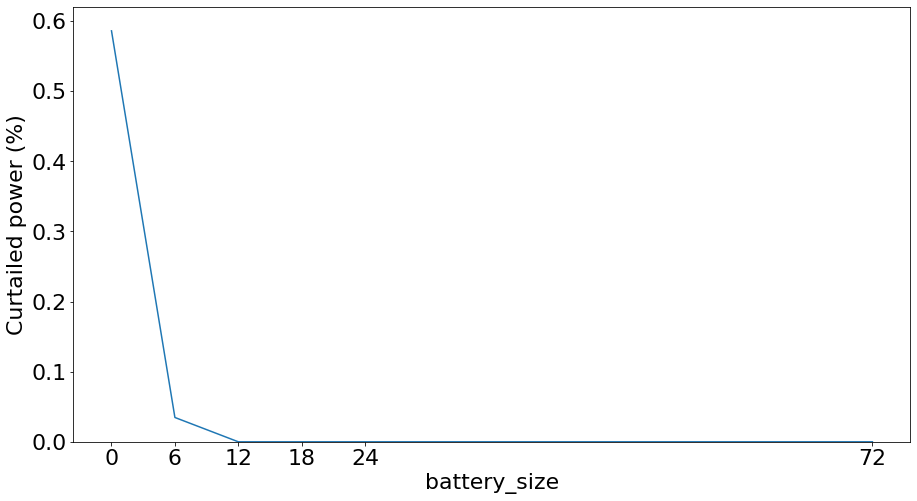

In [160]:
results['curtailment'].plot(xticks = battery_size, ylabel = 'Curtailed power (%)', ylim = ([0, 0.62]));

## EROI calculations

Electricity intensity used for PV production

In [161]:
PV_production_hourly = pd.read_pickle('Calculations/CH/PV_production_CH.pkl')

In [162]:
yearly_PV_production = sum(PV_production_hourly)

In [163]:
electricity_PV_production = 1597 # kWh_el kWp-1

In [164]:
PV_size = 6 #kW_p

In [165]:
results['total_elec_PV_prod'] = electricity_PV_production * PV_size

In [166]:
results['ESOI'] = results['total_savings_kWh'].div(results['total_elec_battery_prod'].where(results['total_elec_battery_prod'] != 0, np.nan))

In [167]:
results['EROI_gen'] = yearly_PV_production*PV_lifetime/results['total_elec_PV_prod']

**Firstly, calculate the EROI for the case where electricity can be made usful through the distribution grid:**

In [168]:
results['EROI_grid_useful'] = results['EROI_gen']

**Now, let's consider the case where power is curtailed unless stored for later use**

In [169]:
results['EROI_grid_curtailed'] = (1 - results['stored'] + eta_discharge * results['stored'])/(1/results['EROI_gen']+results['stored']/results['ESOI'])*(1-results['curtailment'])

In [170]:
results['EROI_grid_curtailed'] = results['EROI_grid_curtailed'].fillna(results['EROI_gen']*(1-results['curtailment']))

In [171]:
results['ESOI'] = results['ESOI'].fillna(0)

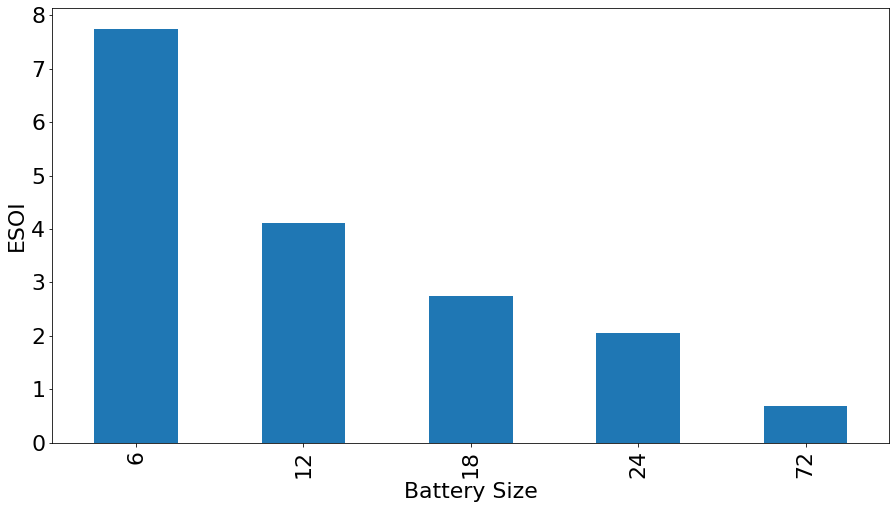

In [172]:
results.ESOI[results['ESOI']!=0].plot.bar(xlabel = 'Battery Size', ylabel = 'ESOI');

In [173]:
results

,curtailment,yearly_savings_kWh,total_savings_kWh,yearly_savings_CO2,total_CO2_grid_reduced,total_elec_battery_prod,total_CO2_battery_prod,net_CO2_savings,stored,total_elec_PV_prod,ESOI,EROI_gen,EROI_grid_useful,EROI_grid_curtailed
battery_size,,,,,,,,,,,,,,
0,0.585891,-0,-0,-0,-0,0.0,0.000000,-0,0,9582,0.000000,22.429791,22.429791,9.288375
6,0.0346766,443.935,11098.4,0.0805743,2.01436,1432.5,0.912502,1.10185,0.551215,9582,7.747563,22.429791,22.429791,7.651476
12,0,471.863,11796.6,0.0856431,2.14108,2865.0,1.825005,0.316074,0.585891,9582,4.117479,22.429791,22.429791,4.880832
18,0,471.863,11796.6,0.0856431,2.14108,4297.5,2.737507,-0.596429,0.585891,9582,2.744986,22.429791,22.429791,3.535005
24,0,471.863,11796.6,0.0856431,2.14108,5730.0,3.650010,-1.50893,0.585891,9582,2.058739,22.429791,22.429791,2.770951
72,0,471.863,11796.6,0.0856431,2.14108,17190.0,10.950030,-8.80895,0.585891,9582,0.686246,22.429791,22.429791,1.015329


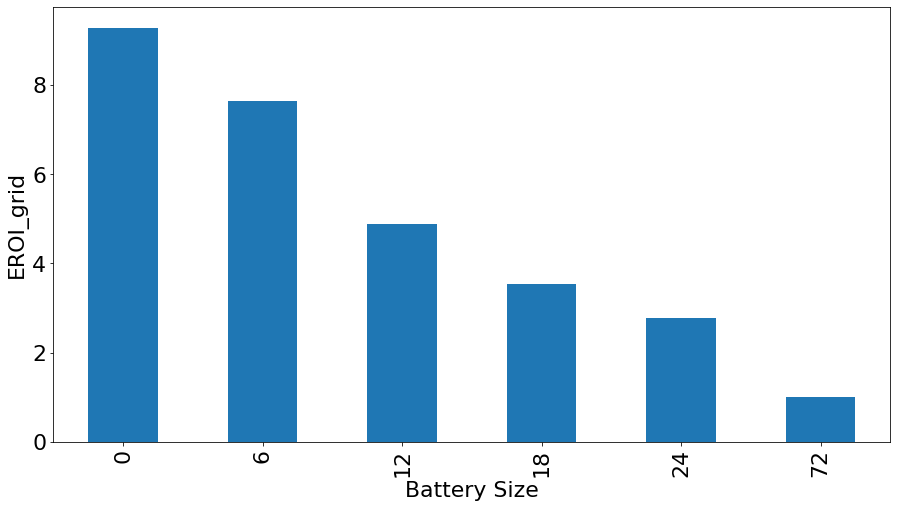

In [174]:
results['EROI_grid_curtailed'].plot.bar(xlabel = 'Battery Size', ylabel = 'EROI_grid');

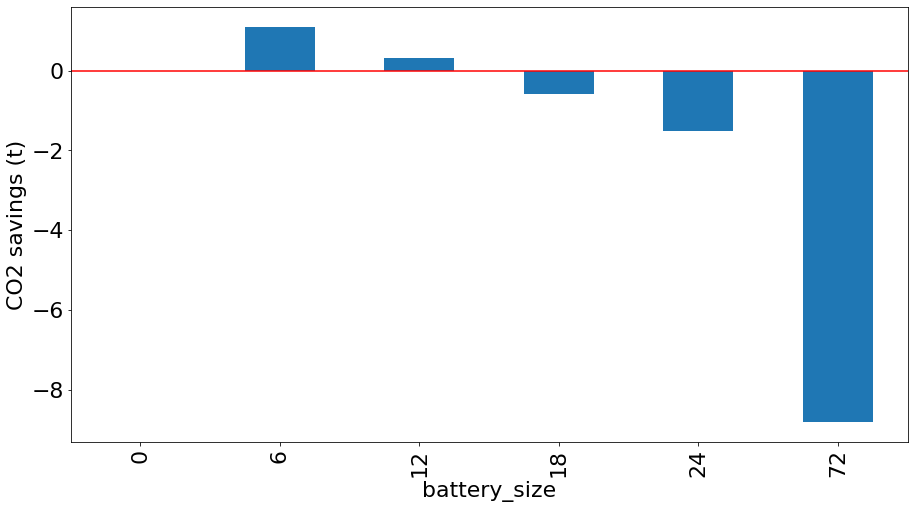

In [175]:
results['net_CO2_savings'].plot.bar(ylabel ='CO2 savings (t)');
plt.axhline(y=0, color='r', linestyle='-')